In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import scipy.io as sio
from PIL import Image
import seaborn as sns
import torch.nn.functional as F
from tqdm.notebook import tqdm
import gc


In [2]:
# Definir rutas
TRAIN_PATH = r"C:\Users\Adrian\Downloads\trainSet"
TEST_PATH = r"C:\Users\Adrian\Downloads\testSet"

# Parámetros de redimensionamiento
# 960x540 mantiene la relación 16:9 y mejor precisión DVA
IMAGE_SIZE = (960, 540)  # ≈ 25.3 x 14.2 DVA

# Verificar que las rutas existen
assert os.path.exists(TRAIN_PATH), f"Train path does not exist: {TRAIN_PATH}"
assert os.path.exists(TEST_PATH), f"Test path does not exist: {TEST_PATH}"

In [3]:
def analyze_mat_structure(root_dir, num_categories=3, num_samples=1):
    """
    Analiza y muestra la estructura de los archivos .mat
    Args:
        root_dir: Directorio raíz del dataset
        num_categories: Número de categorías a analizar
        num_samples: Número de archivos .mat a analizar por categoría
    """
    fixloc_dir = os.path.join(root_dir, 'FIXATIONLOCS')
    categories = [d for d in os.listdir(fixloc_dir) 
                 if os.path.isdir(os.path.join(fixloc_dir, d))]
    
    print("Analizando estructura de archivos .mat...")
    print("-" * 50)
    
    # Tomar solo las primeras num_categories categorías
    for category in categories[:num_categories]:
        category_path = os.path.join(fixloc_dir, category)
        mat_files = [f for f in os.listdir(category_path) if f.endswith('.mat')]
        
        print(f"\nCategoría: {category}")
        
        # Analizar solo el primer archivo de cada categoría
        for mat_file in mat_files[:num_samples]:
            print(f"Archivo: {mat_file}")
            mat_path = os.path.join(category_path, mat_file)
            mat_data = sio.loadmat(mat_path)
            
            # Mostrar estructura
            print("Estructura del archivo:")
            for key in mat_data.keys():
                if not key.startswith('__'):  # Ignorar metadatos
                    print(f"- {key}: {type(mat_data[key])} "
                          f"Shape: {mat_data[key].shape}")
                    
                    # Mostrar valores de ejemplo
                    data = mat_data[key]
                    if data.size > 0:
                        print(f"  Primeros valores: {data.flatten()[:5]}")

# Analizar estructura de archivos .mat
analyze_mat_structure(TRAIN_PATH)

Analizando estructura de archivos .mat...
--------------------------------------------------

Categoría: Action
Archivo: 001.mat
Estructura del archivo:
- fixLocs: <class 'numpy.ndarray'> Shape: (1080, 1920)
  Primeros valores: [0 0 0 0 0]

Categoría: Affective
Archivo: 001.mat
Estructura del archivo:
- fixLocs: <class 'numpy.ndarray'> Shape: (1080, 1920)
  Primeros valores: [0 0 0 0 0]

Categoría: Art
Archivo: 001.mat
Estructura del archivo:
- fixLocs: <class 'numpy.ndarray'> Shape: (1080, 1920)
  Primeros valores: [0 0 0 0 0]


In [ ]:
def denormalize(tensor):
    """
    Desnormaliza un tensor de imagen normalizado con media y std de ImageNet
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).to(tensor.device) #DUDA
    std = torch.tensor([0.229, 0.224, 0.225]).to(tensor.device)
    
    # Añadir dimensiones para broadcasting
    if len(tensor.shape) == 4:  # batch de imágenes
        mean = mean[None, :, None, None]
        std = std[None, :, None, None]
    else:  # imagen única
        mean = mean[:, None, None]
        std = std[:, None, None]
    
    return tensor * std + mean

def tensor_to_numpy(tensor):
    """
    Convierte un tensor a numpy array asegurando el rango [0,1]
    """
    if tensor.is_cuda:
        tensor = tensor.cpu()
    
    # Si es una imagen normalizada (3 canales), desnormalizar
    if tensor.shape[0] == 3:
        tensor = denormalize(tensor)
    
    # Mover canales al final y convertir a numpy
    img = tensor.permute(1, 2, 0).numpy()
    
    # Si es una imagen en escala de grises, eliminar dimensión extra
    if img.shape[-1] == 1:
        img = img.squeeze(-1)
    
    return np.clip(img, 0, 1)

def visualize_sample(dataset, idx):
    """
    Visualiza una muestra del dataset con su mapa de fijación
    """
    sample = dataset[idx]

    fig, axes = plt.subplots(1, 2, figsize=(15, 8))

    # Imagen original
    if isinstance(sample['image'], torch.Tensor):
        # Desnormalizar la imagen
        img = denormalize(sample['image'])
        # Convertir a numpy y asegurar rango [0,1]
        img = img.permute(1, 2, 0).cpu().numpy()
        img = np.clip(img, 0, 1)
    else:
        img = sample['image']

    axes[0].imshow(img)
    axes[0].set_title(f'Imagen Original\nCategoría: {sample["category"]}', fontsize=12)
    axes[0].axis('off')

    # Mapa de fijación
    if isinstance(sample['fixation_map'], torch.Tensor):
        fixmap = sample['fixation_map'].squeeze().cpu().numpy()
    else:
        fixmap = sample['fixation_map']

    # Usar una colormap más intuitiva para mapas de fijación
    im = axes[1].imshow(fixmap, cmap='inferno')
    axes[1].set_title('Mapa de Fijación', fontsize=12)
    axes[1].axis('off')

    # Añadir colorbar con formato mejorado
    cbar = plt.colorbar(im, ax=axes[1])
    cbar.set_label('Intensidad de Fijación', fontsize=10)

    plt.tight_layout()
    plt.show()

In [ ]:
class EyeTrackingDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        
        # Transformaciones base (sin el flip aleatorio)
        self.base_transform = transforms.Compose([
            transforms.Resize(IMAGE_SIZE, antialias=True),
            transforms.ToTensor(),
        ])
        
        # Normalización solo para la imagen RGB
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

        # Obtener lista de todas las imágenes
        self.stimuli_dir = os.path.join(root_dir, 'Stimuli')
        self.fixmap_dir = os.path.join(root_dir, 'FIXATIONMAPS')
        self.fixloc_dir = os.path.join(root_dir, 'FIXATIONLOCS')

        self.categories = [d for d in os.listdir(self.stimuli_dir)
                         if os.path.isdir(os.path.join(self.stimuli_dir, d))]

        self.image_paths = []
        for category in self.categories:
            category_path = os.path.join(self.stimuli_dir, category)
            for img_name in os.listdir(category_path):
                if img_name.endswith(('.jpg', '.png')):
                    self.image_paths.append((category, img_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        category, img_name = self.image_paths[idx]

        # Cargar imagen original
        img_path = os.path.join(self.stimuli_dir, category, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Cargar mapa de fijación
        fixmap_name = os.path.splitext(img_name)[0] + '.jpg'
        fixmap_path = os.path.join(self.fixmap_dir, category, fixmap_name)
        fixation_map = Image.open(fixmap_path).convert('L')
        
        # Cargar ubicaciones de fijación
        fixloc_name = os.path.splitext(img_name)[0] + '.mat'
        fixloc_path = os.path.join(self.fixloc_dir, category, fixloc_name)
        fixation_locs = sio.loadmat(fixloc_path)

        # Aplicar las transformaciones base
        image = self.base_transform(image)
        fixation_map = self.base_transform(fixation_map)

        # Decidir si hacer flip horizontal (misma decisión para ambos)
        if torch.rand(1) < 0.5:  # 50% de probabilidad
            image = transforms.functional.hflip(image)
            fixation_map = transforms.functional.hflip(fixation_map)

        # Aplicar normalización solo a la imagen
        image = self.normalize(image)

        return {
            'image': image,
            'fixation_map': fixation_map,
            'fixation_locs': fixation_locs,
            'category': category
        }

def verify_synchronized_transforms(dataset, num_samples=3):
    """
    Verifica que las transformaciones estén sincronizadas entre
    la imagen y su mapa de fijación
    """
    print("\nVerificando sincronización de transformaciones...")
    
    for i in range(num_samples):
        # Obtener la misma muestra múltiples veces
        idx = np.random.randint(len(dataset))
        samples = [dataset[idx] for _ in range(2)]
        
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        
        for j, sample in enumerate(samples):
            # Desnormalizar la imagen
            img = denormalize(sample['image'])
            img = img.permute(1, 2, 0).cpu().numpy()
            img = np.clip(img, 0, 1)
            
            # Obtener el mapa de fijación
            fixmap = sample['fixation_map'].squeeze().cpu().numpy()
            
            # Mostrar imagen y mapa de fijación
            axes[j, 0].imshow(img)
            axes[j, 0].set_title(f'Imagen {j+1}')
            axes[j, 0].axis('off')
            
            axes[j, 1].imshow(fixmap, cmap='inferno')
            axes[j, 1].set_title(f'Mapa de Fijación {j+1}')
            axes[j, 1].axis('off')
            
            # Mostrar histogramas para verificar distribución
            axes[j, 2].hist(img.ravel(), bins=50)
            axes[j, 2].set_title(f'Histograma Imagen {j+1}')
            
            axes[j, 3].hist(fixmap.ravel(), bins=50)
            axes[j, 3].set_title(f'Histograma Mapa {j+1}')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nMuestra {i+1} de categoría: {sample['category']}")
        print("Si las transformaciones están sincronizadas, ambas filas deberían")
        print("mostrar exactamente la misma imagen y mapa de fijación.")
        input("Presiona Enter para ver la siguiente muestra...")

In [6]:
def verify_image_loading(dataset, num_samples=3):
    """
    Verifica que las imágenes se estén cargando correctamente
    mostrando múltiples ejemplos
    """
    print("\nVerificando carga de imágenes...")
    
    # Obtener índices aleatorios de diferentes categorías
    categories = dataset.categories[:num_samples]
    for category in categories:
        # Encontrar imágenes de esta categoría
        category_indices = [i for i, (cat, _) in enumerate(dataset.image_paths) 
                          if cat == category]
        
        if category_indices:
            idx = np.random.choice(category_indices)
            print(f"\nMostrando ejemplo de categoría: {category}")
            visualize_sample(dataset, idx)

# Crear dataset y verificar
dataset = EyeTrackingDataset(
    root_dir=TRAIN_PATH,
)

In [7]:
def analyze_original_resolutions(root_dir, num_samples=50):
    """
    Analiza las resoluciones originales de las imágenes
    para verificar la consistencia
    
    """
    stimuli_dir = os.path.join(root_dir, 'Stimuli')
    resolutions = []
    
    for category in os.listdir(stimuli_dir):
        category_path = os.path.join(stimuli_dir, category)
        if not os.path.isdir(category_path):
            continue
            
        files = [f for f in os.listdir(category_path) 
                if f.endswith(('.jpg', '.png'))]
        
        # Tomar muestras aleatorias de cada categoría
        samples = np.random.choice(files, 
                                 min(num_samples // len(os.listdir(stimuli_dir)), 
                                     len(files)), 
                                 replace=False)
        
        for img_file in samples:
            img_path = os.path.join(category_path, img_file)
            with Image.open(img_path) as img:
                resolutions.append(img.size)
    
    # Analizar resultados
    unique_resolutions = set(resolutions)
    print("\nResoluciones encontradas:")
    for res in unique_resolutions:
        count = resolutions.count(res)
        print(f"- {res}: {count} imágenes ({count/len(resolutions)*100:.1f}%)")

# Analizar resoluciones originales
analyze_original_resolutions(TRAIN_PATH)


Resoluciones encontradas:
- (1920, 1080): 40 imágenes (100.0%)


Total number of samples: 2000
Number of categories: 20
Categories: ['Action', 'Affective', 'Art', 'BlackWhite', 'Cartoon', 'Fractal', 'Indoor', 'Inverted', 'Jumbled', 'LineDrawing', 'LowResolution', 'Noisy', 'Object', 'OutdoorManMade', 'OutdoorNatural', 'Pattern', 'Random', 'Satelite', 'Sketch', 'Social']

Verificando carga de imágenes...

Mostrando ejemplo de categoría: Action


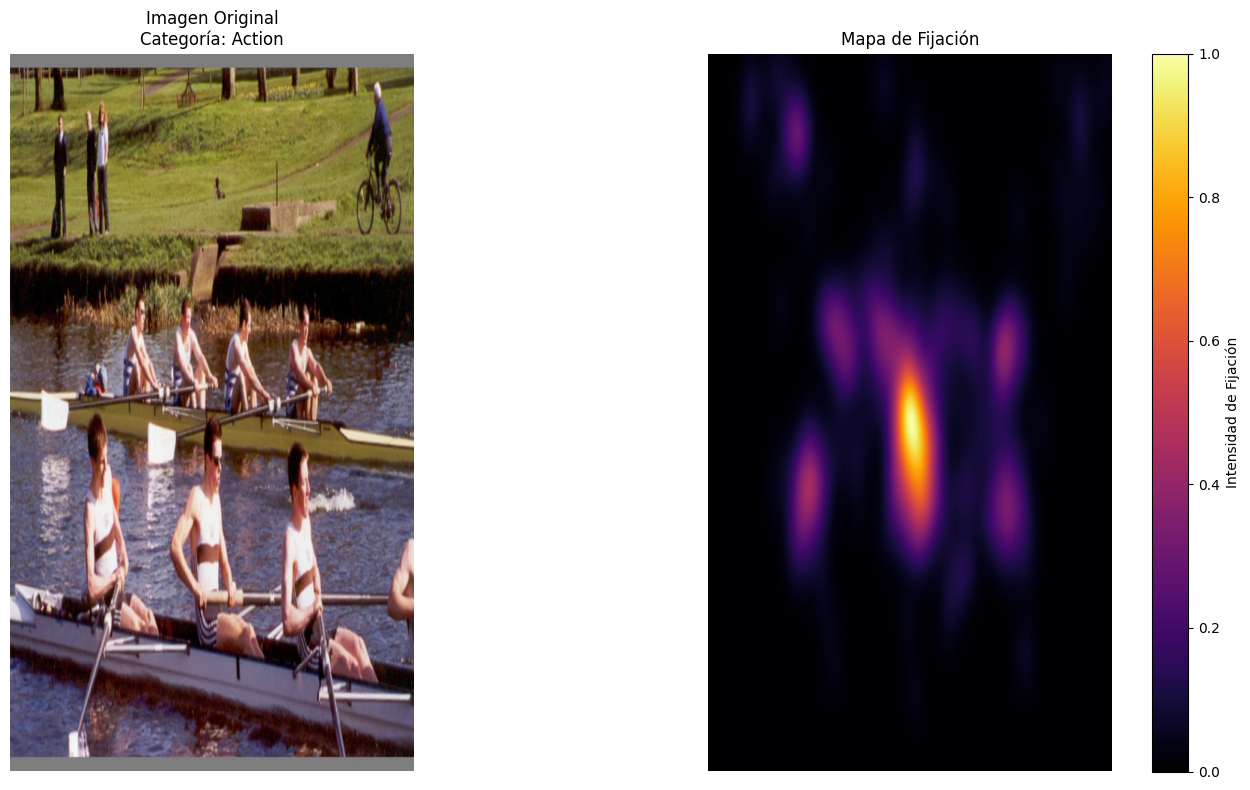


Mostrando ejemplo de categoría: Affective


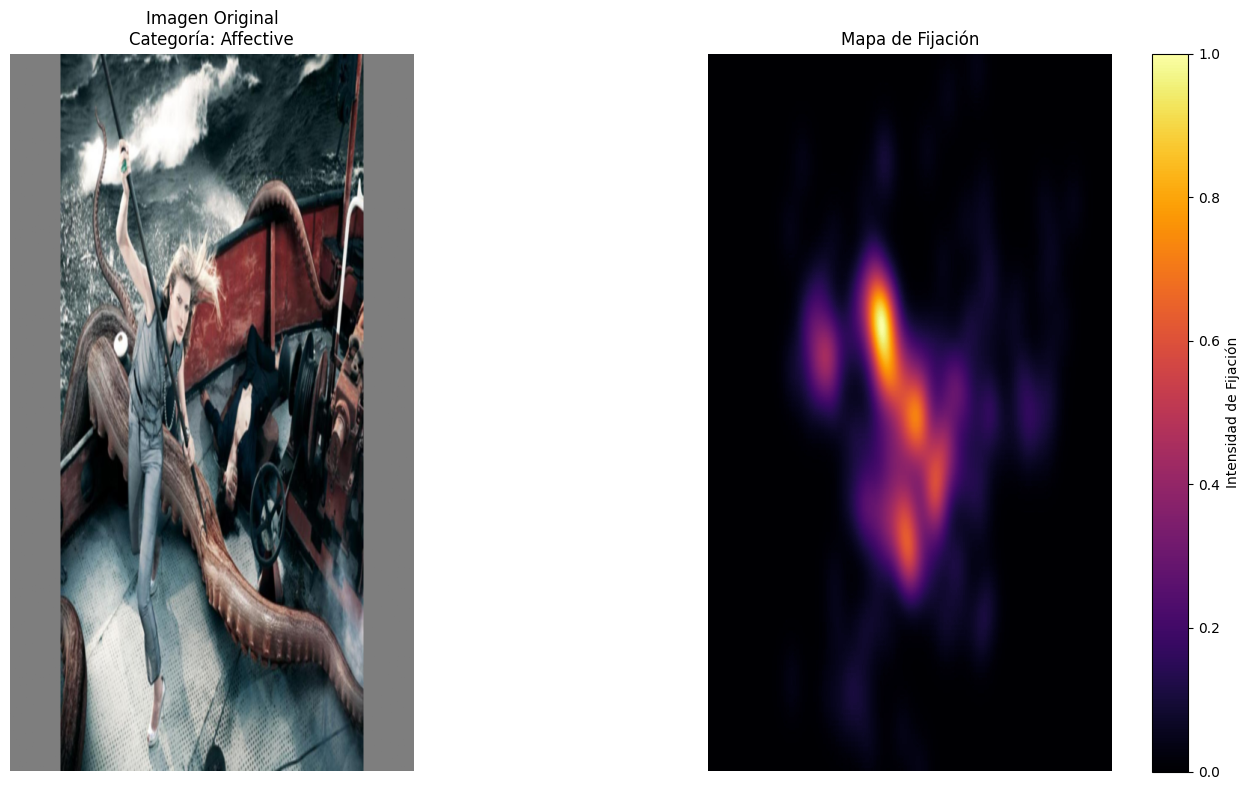


Mostrando ejemplo de categoría: Art


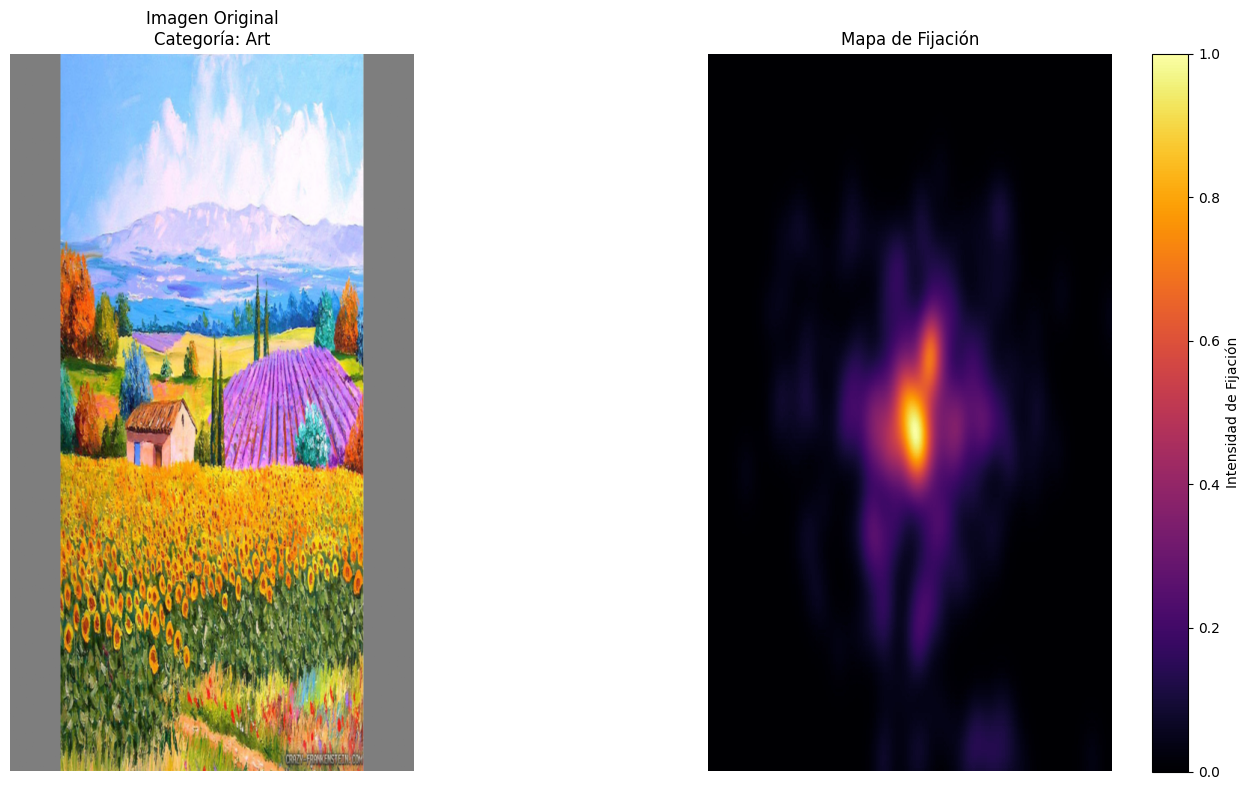

In [8]:
# Crear datasets
train_dataset = EyeTrackingDataset(
    root_dir=TRAIN_PATH,
)

# Información básica
print(f"Total number of samples: {len(train_dataset)}")
print(f"Number of categories: {len(train_dataset.categories)}")
print(f"Categories: {train_dataset.categories}")

# Verificar carga y visualizar muestras
verify_image_loading(train_dataset)

# Analizar dataset
# analyze_dataset(train_dataset)

In [9]:
import torch.nn as nn
import torchvision.models as models

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        
        # Upsampling optimizado para mantener precisión espacial
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            # Kernel 3x3 ≈ 0.08 DVA en la resolución final
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        
        # Bloque de refinamiento con campo receptivo optimizado
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels*2, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape != skip.shape:
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class SaliencyModel(nn.Module):
    def __init__(self):
        super(SaliencyModel, self).__init__()

        # Encoder basado en ResNet50
        resnet = models.resnet50(pretrained=True)

        # Encoder pathway optimizado para 960x540
        # Input: 960x540 (≈25.3x14.2 DVA)
        self.encoder1 = nn.Sequential(
            # Primera capa modificada para preservar detalles finos
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )  # Output: 480x270 (cada píxel ≈ 0.5 DVA)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Output: 240x135 (cada píxel ≈ 1 DVA)

        # Bloques del encoder con correspondencia DVA clara
        self.encoder2 = resnet.layer1  # Output: 240x135 (≈6.3x3.6 DVA)
        self.encoder3 = resnet.layer2  # Output: 120x68  (≈3.2x1.8 DVA)
        self.encoder4 = resnet.layer3  # Output: 60x34   (≈1.6x0.9 DVA)
        self.encoder5 = resnet.layer4  # Output: 30x17   (≈0.8x0.45 DVA)

        # Decoder pathway con skip connections
        # Cada nivel recupera resolución espacial y detalles
        self.decoder1 = DecoderBlock(2048, 1024)  # 60x34
        self.decoder2 = DecoderBlock(1024, 512)   # 120x68
        self.decoder3 = DecoderBlock(512, 256)    # 240x135
        self.decoder4 = DecoderBlock(256, 64)     # 480x270

        # Bloque final para recuperar resolución original
        self.final_upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            # Convoluciones finales para refinamiento de detalles
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # Última capa para generar mapa de saliencia
            nn.Conv2d(32, 1, kernel_size=1)
        )  # Output: 960x540

    def forward(self, x):
        # Guardar dimensiones originales
        original_size = (x.shape[2], x.shape[3])

        # Codificación - preservando información de DVA en cada nivel
        enc1 = self.encoder1(x)           # 480x270
        enc1_pool = self.pool(enc1)       # 240x135
        enc2 = self.encoder2(enc1_pool)   # 240x135
        enc3 = self.encoder3(enc2)        # 120x68
        enc4 = self.encoder4(enc3)        # 60x34
        enc5 = self.encoder5(enc4)        # 30x17

        # Decodificación - recuperando detalles espaciales
        dec1 = self.decoder1(enc5, enc4)  # 60x34
        dec2 = self.decoder2(dec1, enc3)  # 120x68
        dec3 = self.decoder3(dec2, enc2)  # 240x135
        dec4 = self.decoder4(dec3, enc1)  # 480x270

        # Recuperación de resolución original
        out = self.final_upsample(dec4)   # 960x540

        # Asegurar dimensiones exactas
        if out.shape[2:] != original_size:
            out = F.interpolate(out, size=original_size, 
                              mode='bilinear', align_corners=True)

        return out

In [10]:
# Crear modelo y mover a GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SaliencyModel().to(device)

# Imprimir resumen del modelo
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Modelo creado en: {device}")
print(f"Número total de parámetros: {count_parameters(model):,}")

# Verificar si PyTorch detecta la GPU
if torch.cuda.is_available():
    print(f"PyTorch está usando la GPU: {torch.cuda.get_device_name(0)}")
else:
    print("PyTorch no detecta ninguna GPU.")

c:\Users\Adrian\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Adrian\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Modelo creado en: cuda
Número total de parámetros: 85,729,089
PyTorch está usando la GPU: NVIDIA GeForce RTX 3070


In [11]:
def verify_model_dimensions():
    """
    Verifica las dimensiones del modelo y visualiza una muestra
    """
    print("Verificando dimensiones del modelo...")
    model.eval()

    # Tomar una muestra del dataset
    sample = train_dataset[0]
    images = sample['image'].unsqueeze(0).to(device)

    # Imprimir dimensiones de entrada
    print(f"\nDimensiones de entrada:")
    print(f"Batch shape: {images.shape}")

    # Forward pass
    with torch.no_grad():
        output = model(images)
        output = torch.sigmoid(output)

    # Imprimir dimensiones de salida
    print(f"\nDimensiones de salida:")
    print(f"Output shape: {output.shape}")
    print(f"Target shape: {sample['fixation_map'].unsqueeze(0).shape}")

    # Visualizar una muestra
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Imagen original
    original_img = tensor_to_numpy(sample['image'])
    axes[0].imshow(original_img)
    axes[0].set_title('Imagen Original')
    axes[0].axis('off')

    # Mapa de fijación real
    target_map = tensor_to_numpy(sample['fixation_map'])
    im_target = axes[1].imshow(target_map, cmap='inferno')
    axes[1].set_title('Mapa de Fijación Real')
    axes[1].axis('off')
    plt.colorbar(im_target, ax=axes[1])

    # Predicción inicial
    pred_map = output.squeeze().cpu().numpy()
    im_pred = axes[2].imshow(pred_map, cmap='inferno')
    axes[2].set_title('Predicción Inicial')
    axes[2].axis('off')
    plt.colorbar(im_pred, ax=axes[2])

    plt.tight_layout()
    plt.show()

    return True

In [12]:
class CheckpointSaver:
    def __init__(self, save_dir):
        self.save_dir = save_dir
        self.best_loss = float('inf')

        # Crear directorio si no existe
        os.makedirs(save_dir, exist_ok=True)

    def save_checkpoint(self, model, optimizer, epoch, loss, is_best=False):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
        }

        # Guardar checkpoint con número de época
        checkpoint_name = f'checkpoint_epoch_{epoch:03d}.pth'
        torch.save(checkpoint,
                  os.path.join(self.save_dir, checkpoint_name))

        # Guardar mejor modelo con número de época
        if is_best:
            best_model_name = f'best_model_epoch_{epoch:03d}.pth'
            torch.save(checkpoint,
                      os.path.join(self.save_dir, best_model_name))
            print(f"✓ Mejor modelo guardado en época {epoch} con loss: {loss:.4f}")

    def update(self, model, optimizer, epoch, loss):
        is_best = loss < self.best_loss
        if is_best:
            self.best_loss = loss
        self.save_checkpoint(model, optimizer, epoch, loss, is_best)

In [13]:
def visualize_predictions(model, dataset, num_samples=3):
    """
    Visualiza imágenes originales, mapas de fijación reales y predicciones
    """
    model.eval()
    device = next(model.parameters()).device

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = axes[None, :]

    for i in range(num_samples):
        # Obtener muestra aleatoria
        idx = np.random.randint(len(dataset))
        sample = dataset[idx]

        # Obtener predicción
        with torch.no_grad():
            image = sample['image'].unsqueeze(0).to(device)
            pred = model(image)
            pred = torch.sigmoid(pred).squeeze().cpu()

        # Convertir todos los tensores a numpy en rango [0,1]
        original_img = tensor_to_numpy(sample['image'])
        target_map = tensor_to_numpy(sample['fixation_map'])
        pred_map = pred.numpy()

        # Imagen original
        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title(f'Imagen Original\n{sample["category"]}')
        axes[i, 0].axis('off')

        # Mapa de fijación real
        im_target = axes[i, 1].imshow(target_map, cmap='inferno')
        axes[i, 1].set_title('Mapa de Fijación Real')
        axes[i, 1].axis('off')
        plt.colorbar(im_target, ax=axes[i, 1])

        # Predicción
        im_pred = axes[i, 2].imshow(pred_map, cmap='inferno')
        axes[i, 2].set_title('Predicción del Modelo')
        axes[i, 2].axis('off')
        plt.colorbar(im_pred, ax=axes[i, 2])

    plt.tight_layout()
    plt.show()

Iniciando verificación del modelo...

Verificando dimensiones del modelo...

Dimensiones de entrada:
Batch shape: torch.Size([1, 3, 960, 540])

Dimensiones de salida:
Output shape: torch.Size([1, 1, 960, 540])
Target shape: torch.Size([1, 1, 960, 540])


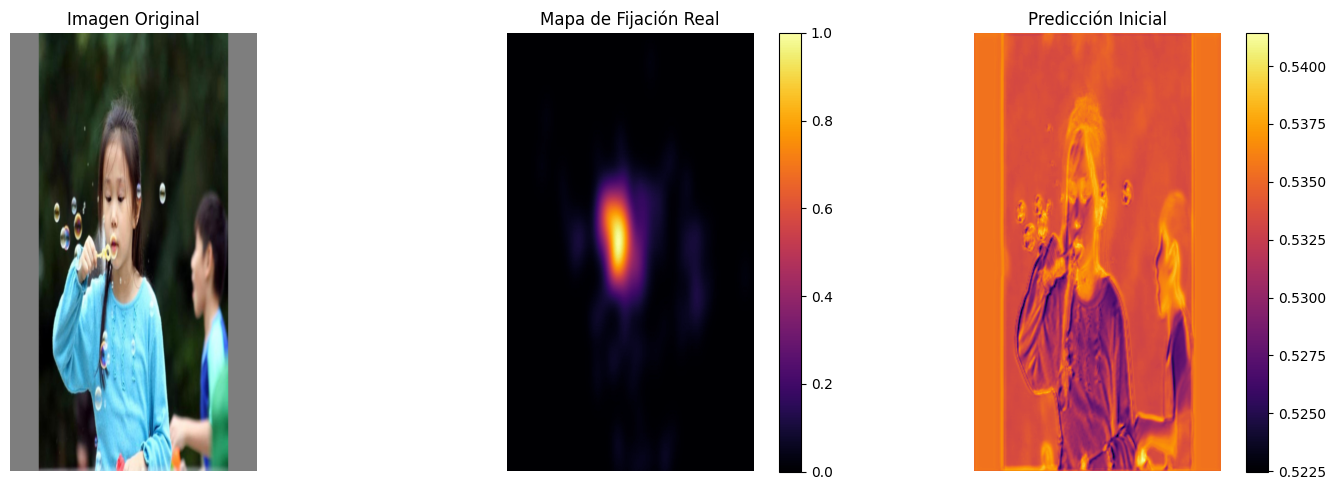


Checkpoint saver configurado en: checkpoints

Generando visualizaciones de prueba...


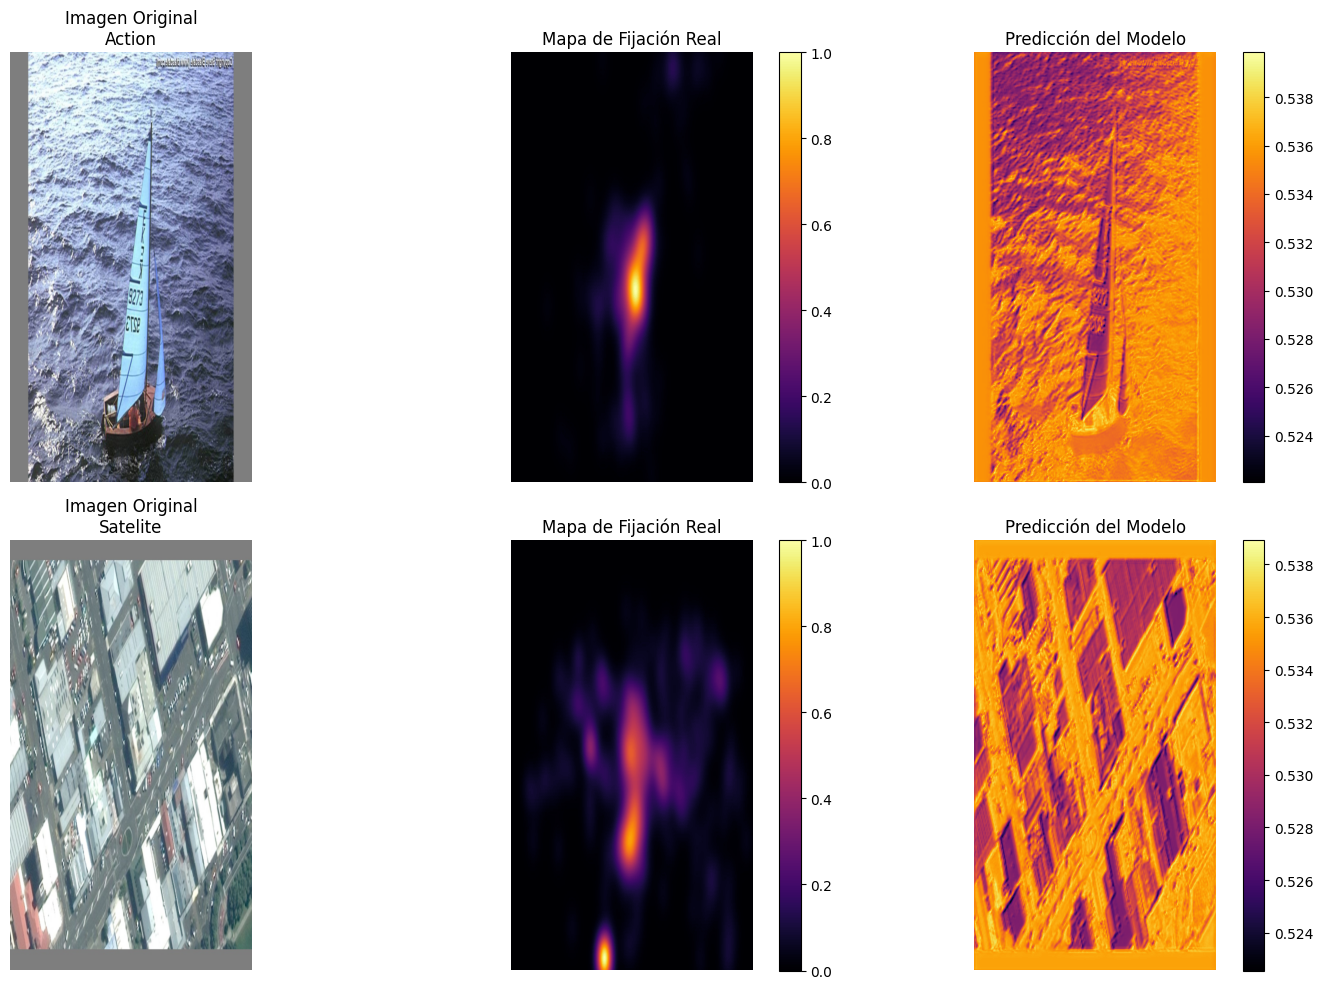

✓ Visualización de predicciones funciona correctamente

✓ ¡Configuración del modelo completada exitosamente!
Verificación completada exitosamente


In [14]:
def verify_model_setup():
    """
    Verifica la configuración completa del modelo
    """
    print("Iniciando verificación del modelo...\n")

    # Verificar dimensiones y visualización
    try:
        verify_model_dimensions()
    except Exception as e:
        print(f"Error en verificación de dimensiones: {e}")
        return False, None

    # Configurar checkpoint saver
    checkpoint_dir = 'checkpoints'
    saver = CheckpointSaver(checkpoint_dir)
    print(f"\nCheckpoint saver configurado en: {checkpoint_dir}")

    # Probar visualización de predicciones
    print("\nGenerando visualizaciones de prueba...")
    try:
        visualize_predictions(model, train_dataset, num_samples=2)
        print("✓ Visualización de predicciones funciona correctamente")
    except Exception as e:
        print(f"Error en visualización: {e}")
        return False, None

    print("\n✓ ¡Configuración del modelo completada exitosamente!")
    return True, saver

# 3. Modificar cómo llamamos a la función
success, checkpoint_saver = verify_model_setup()
if not success:
    print("La verificación del modelo falló")
else:
    print("Verificación completada exitosamente")

In [15]:
# Hiperparámetros
learning_rate = 1e-4
batch_size = 4
num_epochs = 10

# Criterio de pérdida
criterion = nn.BCEWithLogitsLoss()

# Optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # Cambiamos a 0 para debuggear
    pin_memory=True if torch.cuda.is_available() else False
)

In [16]:
# Funciones de entrenamiento
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    # Barra de progreso
    from tqdm.notebook import tqdm
    progress_bar = tqdm(loader, desc='Training')
    
    for batch in progress_bar:
        images = batch['image'].to(device)
        targets = batch['fixation_map'].to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Actualizar métricas
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
    
    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    
    # Barra de progreso
    from tqdm.notebook import tqdm
    progress_bar = tqdm(loader, desc='Validating')
    
    with torch.no_grad():
        for batch in progress_bar:
            images = batch['image'].to(device)
            targets = batch['fixation_map'].to(device)
            
            outputs = model(images)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
    
    return total_loss / len(loader)

In [17]:
def plot_training_progress(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, checkpoint_saver):
    train_losses = []
    val_losses = []
    
    print("Iniciando entrenamiento...")
    
    # Barra de progreso para las épocas
    epoch_bar = tqdm(range(num_epochs), desc='Epochs', position=0)
    
    for epoch in epoch_bar:

        # Limpiar memoria antes de cada época
        gc.collect()
        torch.cuda.empty_cache()

        # Entrenamiento
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        
        # Validación
        val_loss = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        
        # Actualizar barra de progreso principal
        epoch_bar.set_postfix({
            'Train Loss': f'{train_loss:.4f}',
            'Val Loss': f'{val_loss:.4f}'
        })
        
        # Guardar checkpoint
        checkpoint_saver.update(model, optimizer, epoch, val_loss)
        
        # Visualizar progreso
        if (epoch + 1) % 5 == 0:  # cada 5 épocas
            plot_training_progress(train_losses, val_losses)
            visualize_predictions(model, train_dataset)
    
    return train_losses, val_losses

In [19]:
# Preparar datos de validación
from sklearn.model_selection import train_test_split

# Separar dataset en train y validación
train_indices, val_indices = train_test_split(
    range(len(train_dataset)),
    test_size=0.2,
    random_state=42
)

In [ ]:
from torch.utils.data import Subset

train_data = Subset(train_dataset, train_indices)
val_data = Subset(train_dataset, val_indices)

# Crear dataloaders
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

In [ ]:
# Iniciar entrenamiento
print("Configuración del entrenamiento:")
print(f"Device: {device}")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}")
print(f"Epochs: {num_epochs}")
print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

# Entrenar el modelo
train_losses, val_losses = train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    num_epochs, 
    checkpoint_saver
)

# Visualizar resultados finales
plot_training_progress(train_losses, val_losses)

Configuración del entrenamiento:
Device: cuda
Batch size: 4
Learning rate: 0.0001
Epochs: 10
Train samples: 1600
Validation samples: 400
Iniciando entrenamiento...


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]